# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

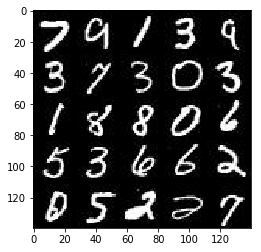

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

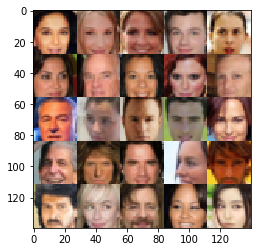

In [3]:
show_n_images = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, (None))
    
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    print(images)
    alpha = 0.2
    dropout = 0.3
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        h1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=None)
        h1 = tf.nn.dropout(h1, dropout)
        h1 = tf.maximum(alpha * h1, h1)

        print(h1)
        # 24x24x64
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=None)
        h2 = tf.nn.dropout(h2, dropout)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        # 12x12x128
        print(h2)
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=None)
        h3 = tf.nn.dropout(h3, dropout)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        print(h3)
            
        # flatten
        flat = tf.reshape(h3, shape=(-1, 6 * 6 * 256 ))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("Maximum_3:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("Maximum_4:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("Maximum_5:0", shape=(?, 6, 6, 256), dtype=float32)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    dropout = 0.5
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 6*6*256)
        print(x1)
        # Reshape it to start the convolutional stack
        x2 = tf.reshape(x1, (-1, 6, 6, 256))
        x2 = tf.nn.dropout(x2, dropout)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        # 6x6x256 now
        print(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, dropout)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # 12x12x128 now
        print(x3)
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x4 = tf.nn.dropout(x4, dropout)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        # 24 x 24 x 64
        print(x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("logits generator")
        print(logits)
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("Maximum_3:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("Maximum_4:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("Maximum_5:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("conv2d_transpose_6/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_total_losss = d_loss_real + d_loss_fake
    
    return d_total_losss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("Placeholder:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("discriminator/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("discriminator_1/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator_1/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator_1/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    variables = tf.trainable_variables()
    
    gen_vars = [variable for variable in variables if variable.name.startswith('generator')]
    dis_vars =[variable for variable in variables if variable.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_var)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_var)
        
    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = dis_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = gen_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    real_input, fake_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, fake_input, image_channels )
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # batch images
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                step += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, fake_input: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={fake_input: batch_z, real_input: batch_images, lr:learning_rate})
                
              
                
                if ( step % 100 == 0):
                    show_generator_output(sess, 10, fake_input, image_channels, data_image_mode )
                
                if ( step % 10 == 0):
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({fake_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({fake_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("generator/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator_1/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator_1/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator_1/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Epoch 1/2... Discriminator Loss: 1.0798... Generat

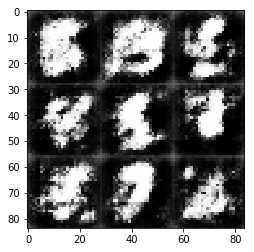

Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 1.8846
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.5751
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.1705
Tensor("generator_2/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_2/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_2/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_2/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_2/conv2d_transpose_3/

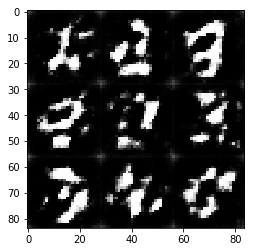

Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 1.5857
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 1.5720
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 2.0339
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 1.0714
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.8682
Tensor("generator_3/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_3/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_3/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_3/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_3/conv2d_transpose_3/

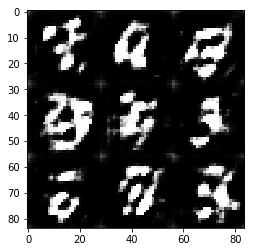

Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 2.2647
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 1.6121
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.6749
Tensor("generator_4/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_4/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_4/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_4/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_4/conv2d_transpose_3/

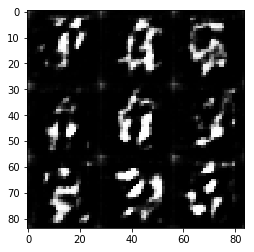

Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 1.3925
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 1.7392
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 1.2987
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 2.1990
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 1.8734
Tensor("generator_5/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_5/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_5/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_5/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_5/conv2d_transpose_3/

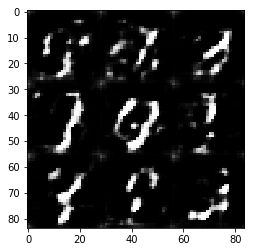

Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 1.7542
Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 2.1878
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 2.0927
Tensor("generator_6/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_6/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_6/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_6/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_6/conv2d_transpose_3/

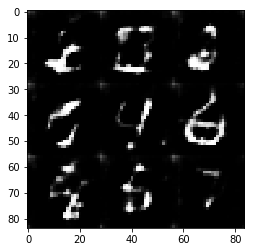

Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.4370
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.3682
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 1.7602
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.3920
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.6706
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.2357
Tensor("generator_7/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_7/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_7/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_7/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_7/conv2d_transpose_3/

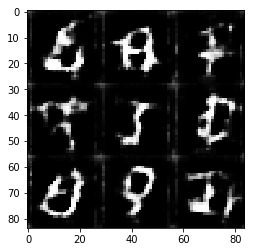

Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 2.0070
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.3517
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 1.4389
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 2.1891
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.3425
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 1.2846
Tensor("generator_8/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_8/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_8/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_8/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_8/conv2d_transpose_3/

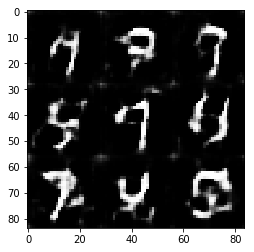

Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 1.7297
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.3195
Tensor("generator_9/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_9/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_9/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_9/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_9/conv2d_transpose_3/

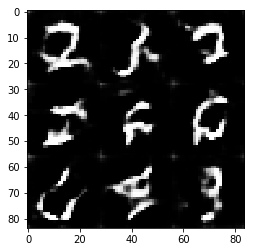

Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 1.2432
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 2.0854
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.6741
Tensor("generator_10/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_10/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_10/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_10/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_10/conv2d_transpo

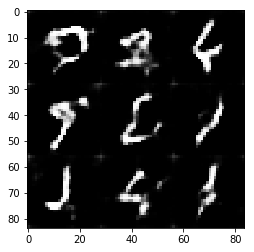

Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.5666
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 1.6184
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.3564
Tensor("generator_11/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_11/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_11/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_11/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_11/conv2d_transpo

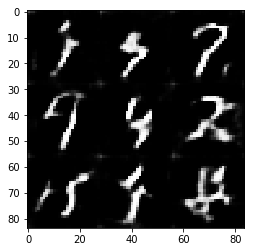

Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 1.3752
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 1.6378
Tensor("generator_12/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_12/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_12/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_12/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_12/conv2d_transpo

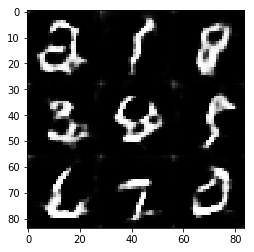

Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.8353
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 2.0488
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.6353
Tensor("generator_13/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_13/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_13/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_13/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_13/conv2d_transpo

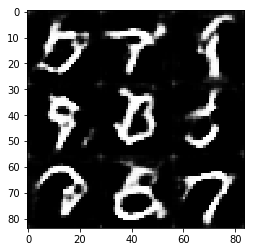

Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 1.3799
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 1.4746
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.3593
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 1.5444
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 1.4799
Tensor("generator_14/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_14/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_14/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_14/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_14/conv2d_transpo

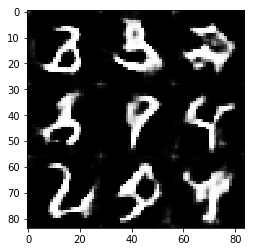

Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 1.8120
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 1.2779
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.7937
Tensor("generator_15/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_15/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_15/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_15/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_15/conv2d_transpo

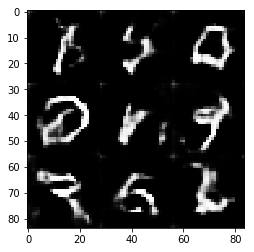

Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 1.8018
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 2.0263
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.1603
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 1.4249
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 0.9232
Tensor("generator_16/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_16/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_16/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_16/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_16/conv2d_transpo

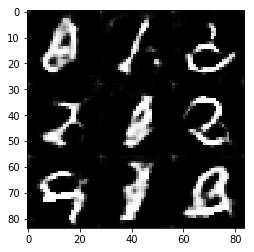

Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.3377
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 1.2374
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.0574
Tensor("generator_17/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_17/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_17/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_17/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_17/conv2d_transpo

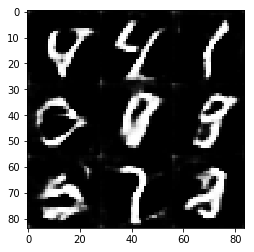

Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 2.0919
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.1069
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 1.5733
Tensor("generator_18/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_18/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_18/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_18/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_18/conv2d_transpo

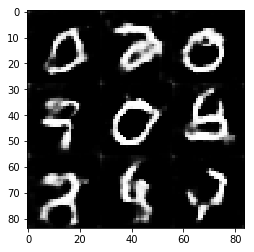

Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 1.0726
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 1.7604
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 1.2279
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.3016
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 1.0007
Tensor("generator_19/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_19/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_19/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_19/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_19/conv2d_transpo

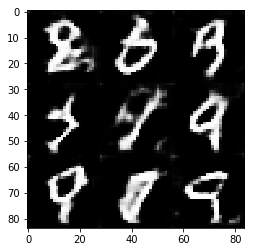

Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 1.7955
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 1.6055
Tensor("generator_20/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_20/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_20/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_20/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_20/conv2d_transpo

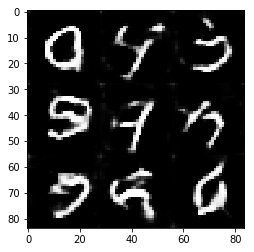

Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 2.0756
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 1.5703
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 1.1796
Tensor("generator_21/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_21/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_21/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_21/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_21/conv2d_transpo

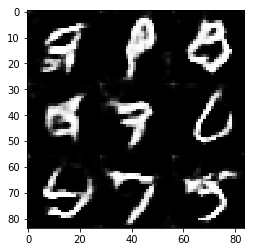

Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.1825
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 1.0034
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.4312
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 1.0413
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 1.2256
Tensor("generator_22/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_22/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_22/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_22/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_22/conv2d_transpo

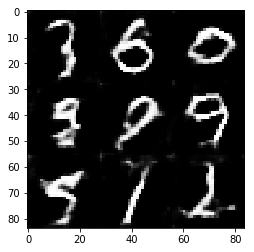

Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.1946
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.0903
Tensor("generator_23/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_23/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_23/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_23/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_23/conv2d_transpo

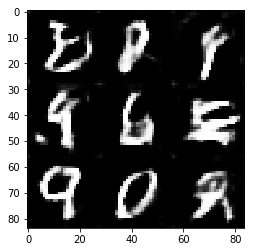

Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.5071
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.6862
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 1.4360
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 1.9608
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.5038
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 1.8353
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.1195
Tensor("generator_24/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_24/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_24/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_24/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_24/conv2d_transpo

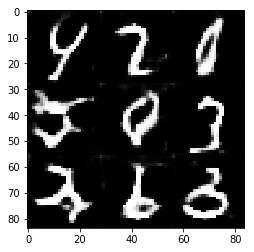

Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.5529
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 1.4274
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.8213
Tensor("generator_25/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_25/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_25/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_25/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_25/conv2d_transpo

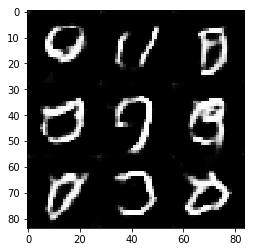

Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 1.6659
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 1.0560
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 1.4210
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 1.5725
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 1.2304
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.9826
Tensor("generator_26/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_26/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_26/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_26/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_26/conv2d_transpo

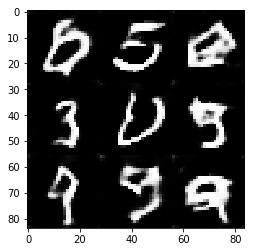

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 1.4771
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.4626
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 1.6002... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.3540
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.7975
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 1.8406
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 1.9518
Tensor("generator_27/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_27/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_27/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_27/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_27/conv2d_transpo

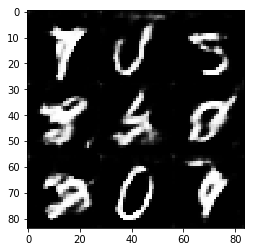

Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.2715
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 1.1631
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 1.6352
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 1.7730
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 2.1592
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 1.4366
Tensor("generator_28/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_28/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_28/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_28/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_28/conv2d_transpo

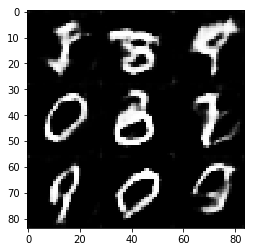

Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 1.7285
Epoch 2/2... Discriminator Loss: 1.0963... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 1.0965
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 1.2448
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 1.7112
Tensor("generator_29/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_29/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_29/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_29/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_29/conv2d_transpo

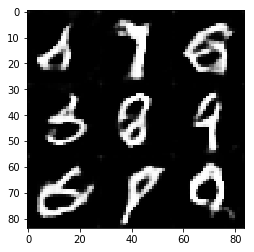

Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.7614
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 2.1610
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 1.2629
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.7627
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.4080
Tensor("generator_30/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_30/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_30/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_30/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_30/conv2d_transpo

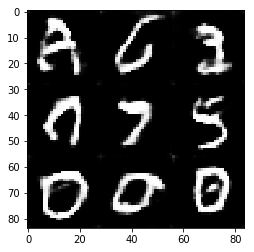

Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0477
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 2.3330
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 1.2777
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.5342
Tensor("generator_31/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_31/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_31/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_31/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_31/conv2d_transpo

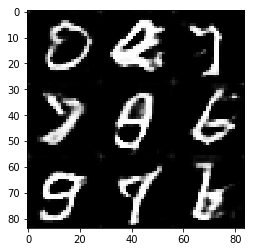

Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 1.6885
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 2.0452
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 1.4166
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.6606
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.9187
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 1.3391
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.4533
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.2333
Tensor("generator_32/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_32/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_32/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_32/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_32/conv2d_transpo

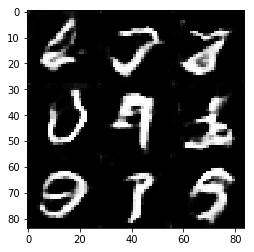

Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.5723
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 2.0326
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.7086
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 1.5347
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 1.4758
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.9297
Tensor("generator_33/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_33/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_33/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_33/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_33/conv2d_transpo

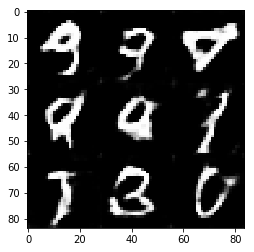

Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 2.2345
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 2.0613
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.7829
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.5065
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.9397
Tensor("generator_34/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_34/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_34/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_34/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_34/conv2d_transpo

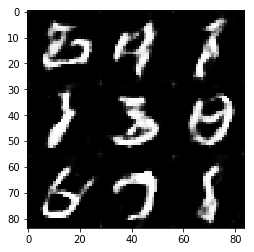

Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 1.4531
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 2.3249
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 1.4938
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.6616
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.8784
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 1.9472
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.8293
Tensor("generator_35/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_35/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_35/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_35/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_35/conv2d_transpo

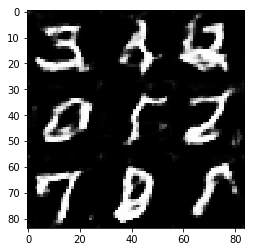

Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 1.5419
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 1.5461
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.5379
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 2.2173
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.6846
Tensor("generator_36/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_36/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_36/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_36/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_36/conv2d_transpo

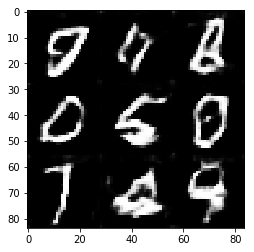

Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 1.7277
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.6089
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.6857
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 1.9870
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.8716
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.4186
Tensor("generator_37/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_37/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_37/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_37/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_37/conv2d_transpo

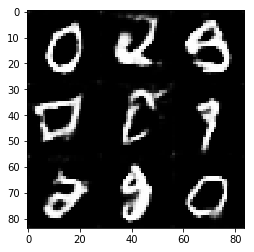

Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 1.8838
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 2.1892


In [17]:
batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("generator/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("discriminator/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("discriminator_1/Maximum:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("discriminator_1/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("discriminator_1/Maximum_2:0", shape=(?, 6, 6, 256), dtype=float32)
Epoch 1/1... Discriminator Loss: 0.9121... Generat

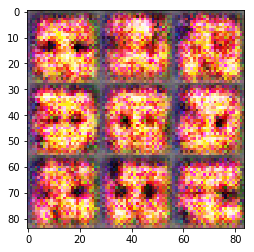

Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 3.0320
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 3.1641
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.1335
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 2.9631
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 4.6786
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.4041
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 4.0387
Tensor("generator_2/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_2/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_2/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_2/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_2/conv2d_transpose_3/

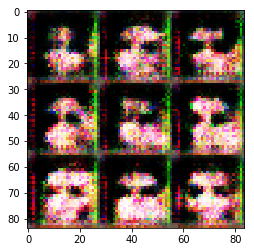

Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 4.9500
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 4.8646
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 4.6645
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 4.9717
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 4.0643
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 5.2204
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 5.0340
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 2.5675
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.9135
Tensor("generator_3/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_3/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_3/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_3/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_3/conv2d_transpose_3/

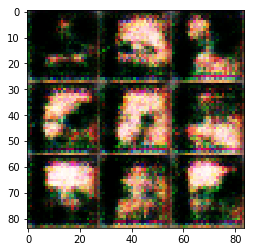

Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 4.2305
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 4.8461
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 4.5933
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.6103
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 4.0459
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 2.3764
Tensor("generator_4/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_4/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_4/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_4/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_4/conv2d_transpose_3/

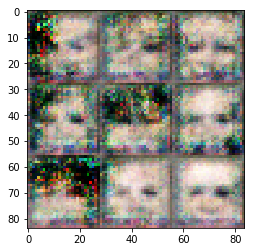

Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 2.1760
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.3256
Tensor("generator_5/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_5/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_5/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_5/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_5/conv2d_transpose_3/

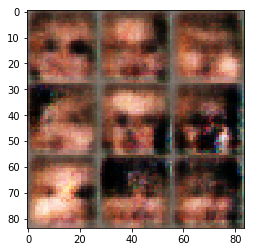

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 2.6213
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.7885
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.1042
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.9586
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.8057
Tensor("generator_6/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_6/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_6/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_6/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_6/conv2d_transpose_3/

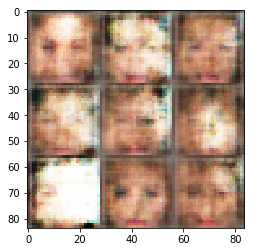

Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.7349
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 2.6081
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 2.9301
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.9273
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.5320
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 4.1376
Tensor("generator_7/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_7/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_7/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_7/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_7/conv2d_transpose_3/

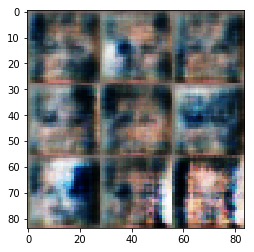

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.8562
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.8874
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 3.1597
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 4.5265
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 2.4697
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 2.4669
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.9381
Tensor("generator_8/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_8/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_8/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_8/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_8/conv2d_transpose_3/

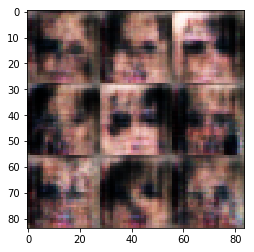

Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 2.1586
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 2.6963
Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 2.7903
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.8908
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 2.0477
Tensor("generator_9/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_9/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_9/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_9/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_9/conv2d_transpose_3/

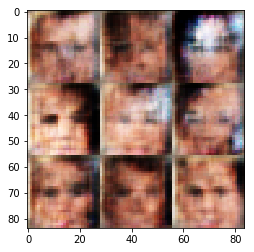

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.9923
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.7580
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 2.0538
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 2.0148... Generator Loss: 3.2724
Tensor("generator_10/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_10/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_10/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_10/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_10/conv2d_transpo

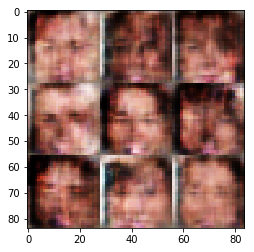

Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 2.6987
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.8040
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 2.7165
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 2.2556
Tensor("generator_11/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_11/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_11/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_11/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_11/conv2d_transpo

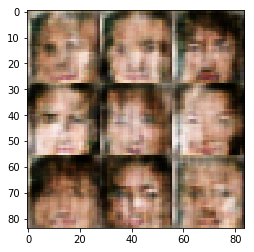

Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 2.6609
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 2.5372
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.8213
Tensor("generator_12/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_12/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_12/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_12/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_12/conv2d_transpo

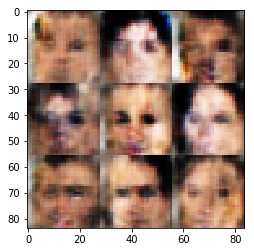

Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.7831
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.7060
Tensor("generator_13/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_13/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_13/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_13/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_13/conv2d_transpo

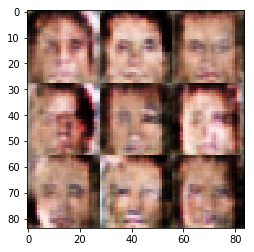

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.7676
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 2.2216
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 2.8727
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.6400
Tensor("generator_14/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_14/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_14/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_14/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_14/conv2d_transpo

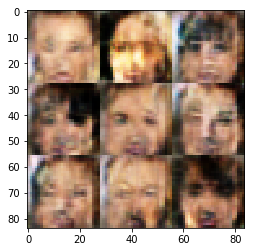

Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.8765
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.2719
Tensor("generator_15/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_15/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_15/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_15/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_15/conv2d_transpo

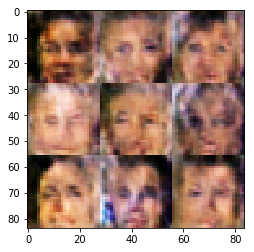

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.5009
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.8159
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 2.5900
Epoch 1/1... Discriminator Loss: 1.7726... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.5458
Tensor("generator_16/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_16/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_16/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_16/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_16/conv2d_transpo

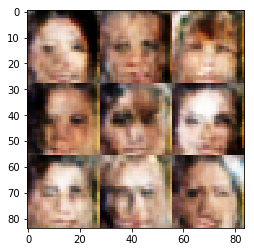

Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.9644
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.8916
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.6300
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.7943
Tensor("generator_17/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_17/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_17/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_17/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_17/conv2d_transpo

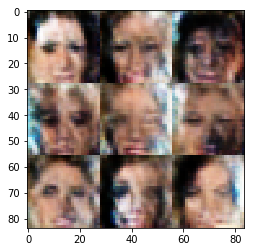

Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.9258
Tensor("generator_18/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_18/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_18/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_18/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_18/conv2d_transpo

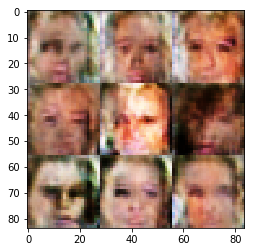

Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.7381
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.0682
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.1661
Tensor("generator_19/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_19/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_19/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_19/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_19/conv2d_transpo

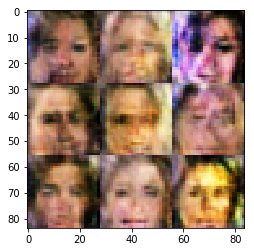

Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 2.5688
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 2.3117
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 2.0286
Tensor("generator_20/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_20/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_20/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_20/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_20/conv2d_transpo

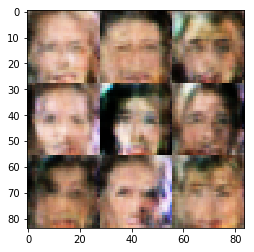

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 2.4966
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 2.1648
Tensor("generator_21/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_21/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_21/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_21/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_21/conv2d_transpo

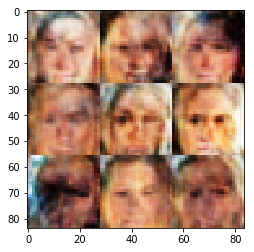

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.5430
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.7269
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.7200
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.2577
Tensor("generator_22/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_22/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_22/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_22/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_22/conv2d_transpo

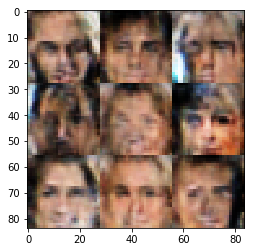

Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.8655
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.9520
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 2.1412
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.3571
Tensor("generator_23/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_23/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_23/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_23/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_23/conv2d_transpo

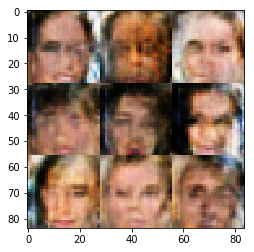

Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.8287
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.4454
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.3187
Tensor("generator_24/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_24/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_24/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_24/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_24/conv2d_transpo

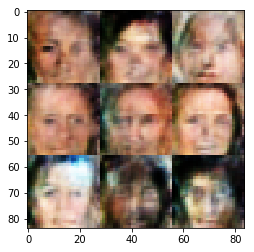

Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.9188
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2890
Tensor("generator_25/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_25/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_25/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_25/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_25/conv2d_transpo

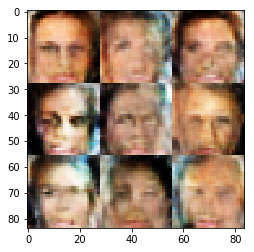

Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.6256
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.8521
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.0089
Tensor("generator_26/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_26/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_26/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_26/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_26/conv2d_transpo

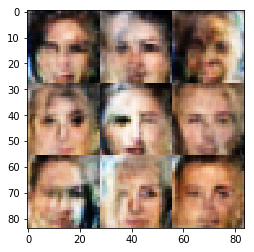

Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.8269
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.5611
Tensor("generator_27/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_27/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_27/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_27/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_27/conv2d_transpo

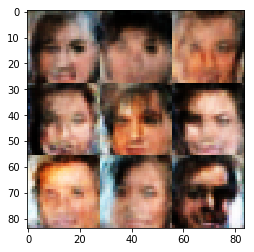

Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 2.1526
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.7342
Tensor("generator_28/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_28/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_28/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_28/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_28/conv2d_transpo

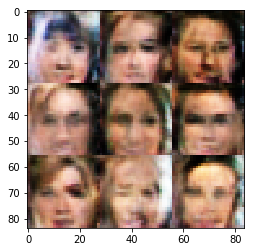

Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.7302
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.6712
Tensor("generator_29/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_29/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_29/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_29/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_29/conv2d_transpo

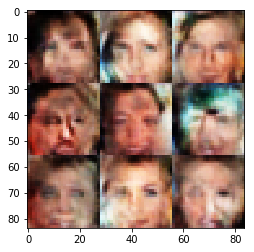

Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.7576
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 2.3170
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.4848
Tensor("generator_30/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_30/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_30/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_30/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_30/conv2d_transpo

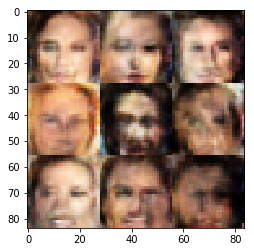

Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 2.1394
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.0421
Tensor("generator_31/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_31/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_31/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_31/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_31/conv2d_transpo

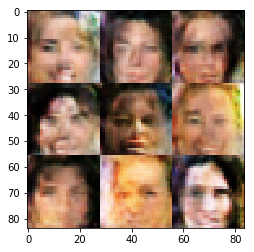

Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.3702
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 2.1167
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.4451
Tensor("generator_32/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_32/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_32/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_32/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_32/conv2d_transpo

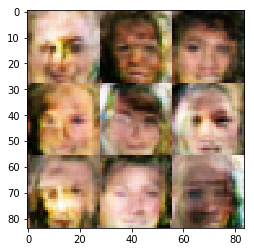

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.8670
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 2.0322
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.4142
Tensor("generator_33/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_33/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_33/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_33/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_33/conv2d_transpo

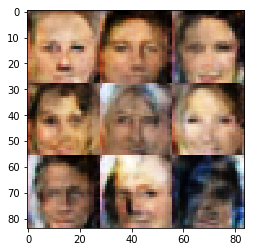

Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 2.1180
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.8241
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.9353
Tensor("generator_34/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_34/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_34/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_34/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_34/conv2d_transpo

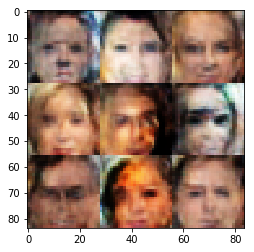

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 0.8800
Tensor("generator_35/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_35/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_35/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_35/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_35/conv2d_transpo

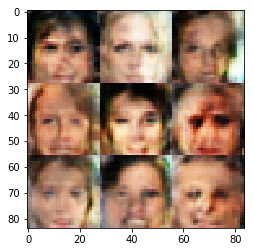

Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 2.1610
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 2.0523
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1841
Tensor("generator_36/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_36/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_36/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_36/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_36/conv2d_transpo

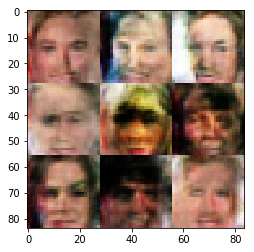

Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 2.1180
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.4348
Tensor("generator_37/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_37/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_37/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_37/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_37/conv2d_transpo

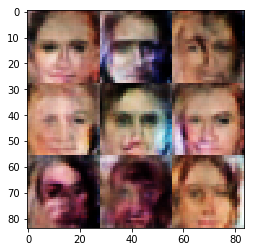

Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.6745
Tensor("generator_38/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_38/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_38/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_38/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_38/conv2d_transpo

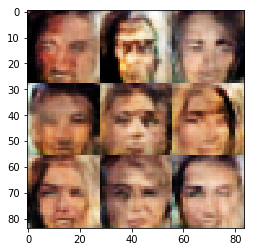

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.7618
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.6236
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.6508
Tensor("generator_39/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_39/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_39/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_39/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_39/conv2d_transpo

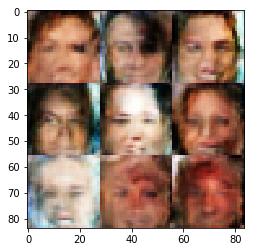

Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.8156
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.7977
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 2.7396
Tensor("generator_40/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_40/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_40/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_40/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_40/conv2d_transpo

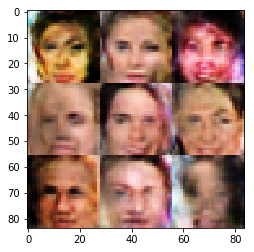

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.5912
Tensor("generator_41/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_41/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_41/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_41/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_41/conv2d_transpo

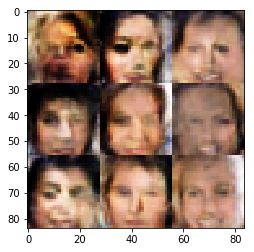

Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.4401
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.1858
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.7356
Tensor("generator_42/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_42/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_42/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_42/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_42/conv2d_transpo

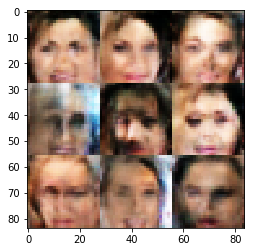

Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.1516
Tensor("generator_43/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_43/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_43/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_43/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_43/conv2d_transpo

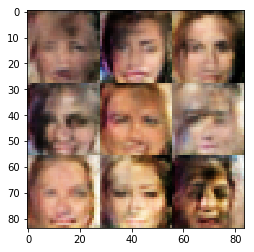

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.8275
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.9040
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.3735
Tensor("generator_44/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_44/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_44/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_44/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_44/conv2d_transpo

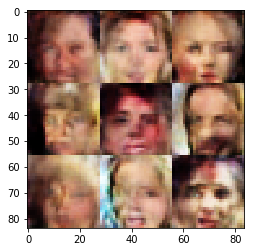

Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 2.2854
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.9657
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.6860
Tensor("generator_45/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_45/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_45/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_45/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_45/conv2d_transpo

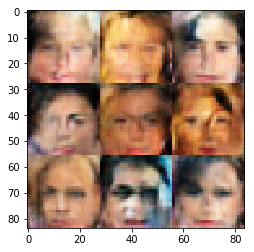

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.8881
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.3454
Tensor("generator_46/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_46/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_46/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_46/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_46/conv2d_transpo

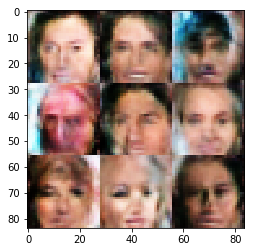

Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 1.1936
Tensor("generator_47/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_47/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_47/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_47/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_47/conv2d_transpo

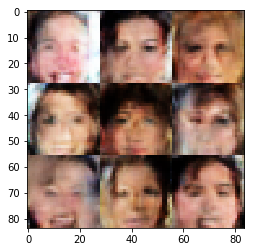

Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.6990
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.3453
Tensor("generator_48/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_48/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_48/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_48/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_48/conv2d_transpo

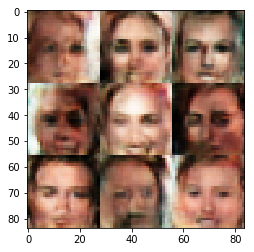

Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.9369
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.9447
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.3839
Tensor("generator_49/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_49/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_49/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_49/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_49/conv2d_transpo

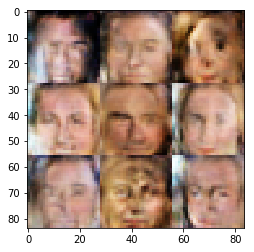

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.7103
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.9937
Tensor("generator_50/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_50/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_50/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_50/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_50/conv2d_transpo

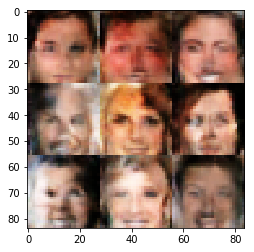

Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 2.0952
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8967
Tensor("generator_51/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_51/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_51/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_51/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_51/conv2d_transpo

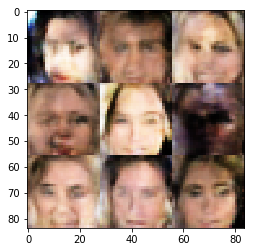

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.5902
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.5949
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.3118
Tensor("generator_52/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_52/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_52/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_52/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_52/conv2d_transpo

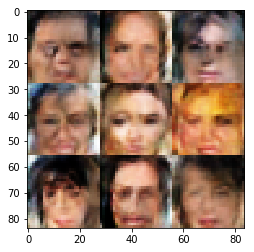

Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 2.5900
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0007
Tensor("generator_53/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_53/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_53/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_53/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_53/conv2d_transpo

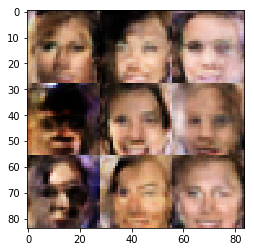

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.8728
Tensor("generator_54/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_54/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_54/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_54/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_54/conv2d_transpo

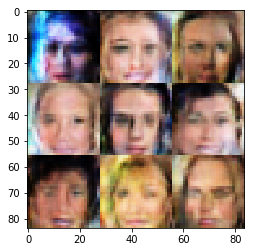

Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.4114
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.8326
Tensor("generator_55/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_55/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_55/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_55/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_55/conv2d_transpo

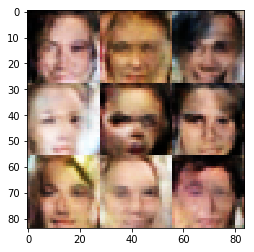

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.6615
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.8492
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9086
Tensor("generator_56/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_56/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_56/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_56/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_56/conv2d_transpo

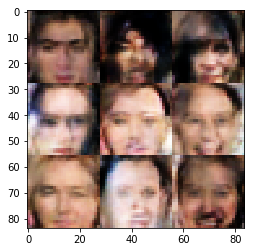

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.9403
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 2.4451
Tensor("generator_57/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_57/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_57/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_57/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_57/conv2d_transpo

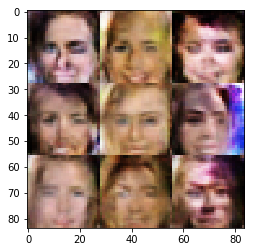

Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.6198
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.1114
Tensor("generator_58/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_58/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_58/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_58/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_58/conv2d_transpo

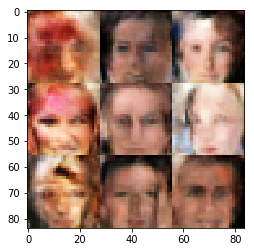

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 2.1574
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.7919
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7766
Tensor("generator_59/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_59/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_59/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_59/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_59/conv2d_transpo

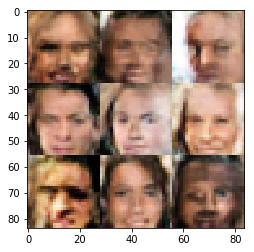

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.7271
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5345
Tensor("generator_60/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_60/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_60/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_60/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_60/conv2d_transpo

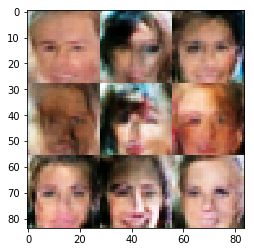

Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.5341
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 2.2596
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 2.0287
Tensor("generator_61/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_61/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_61/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_61/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_61/conv2d_transpo

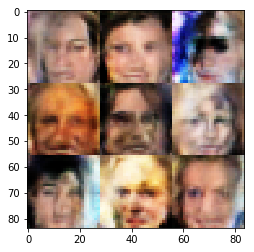

Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 2.3610
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.2209
Tensor("generator_62/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_62/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_62/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_62/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_62/conv2d_transpo

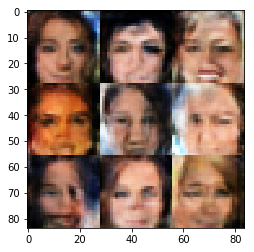

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.6748
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 2.1405
Tensor("generator_63/dense/BiasAdd:0", shape=(?, 9216), dtype=float32)
Tensor("generator_63/Maximum:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("generator_63/Maximum_1:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("generator_63/Maximum_2:0", shape=(?, 24, 24, 64), dtype=float32)
logits generator
Tensor("generator_63/conv2d_transpo

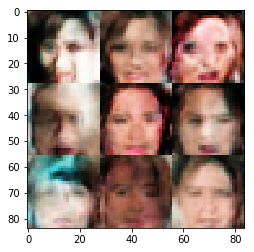

Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.3604


In [18]:
batch_size = 32
z_dim = 200
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.